In [20]:
import numpy as np
from utils import *
from full_model import PseTae
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
ROOT_DIR = "timematch_data"
SOURCE_DIR = "denmark/32VNH/2017"
TARGET_DIR = "timematch_data/denmark/32VNH/2017"
OUTPUT_DIR = "/content/outputs"
NUM_FOLDS = 5
EPOCHS = 10

In [3]:
classes = get_classes("denmark")
dataset = PixelSetData(ROOT_DIR, SOURCE_DIR, classes, with_extra=False)
print(len(dataset))
print(len(classes))
print(dataset[0].keys())
print(dataset[0])

4996
17
dict_keys(['index', 'parcel_index', 'pixels', 'valid_pixels', 'positions', 'extra', 'label'])
{'index': 0, 'parcel_index': 0, 'pixels': array([[[1749, 1726, 1807, ..., 1839, 1856, 1889],
        [1214, 1188, 1201, ..., 1283, 1300, 1318],
        [1185, 1160, 1169, ..., 1333, 1290, 1315],
        ...,
        [2196, 2141, 2056, ..., 1962, 2046, 1954],
        [1396, 1394, 1276, ..., 1022, 1050,  970],
        [ 859,  855,  816, ...,  682,  708,  658]],

       [[1193, 1178, 1198, ..., 3014, 3054, 3096],
        [ 812,  810,  803, ..., 2564, 2554, 2646],
        [ 659,  676,  681, ..., 2638, 2714, 2820],
        ...,
        [1013,  994, 1039, ..., 3245, 3232, 3312],
        [ 887,  893,  905, ..., 2628, 2650, 2726],
        [ 528,  534,  550, ..., 2021, 2034, 2096]],

       [[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0

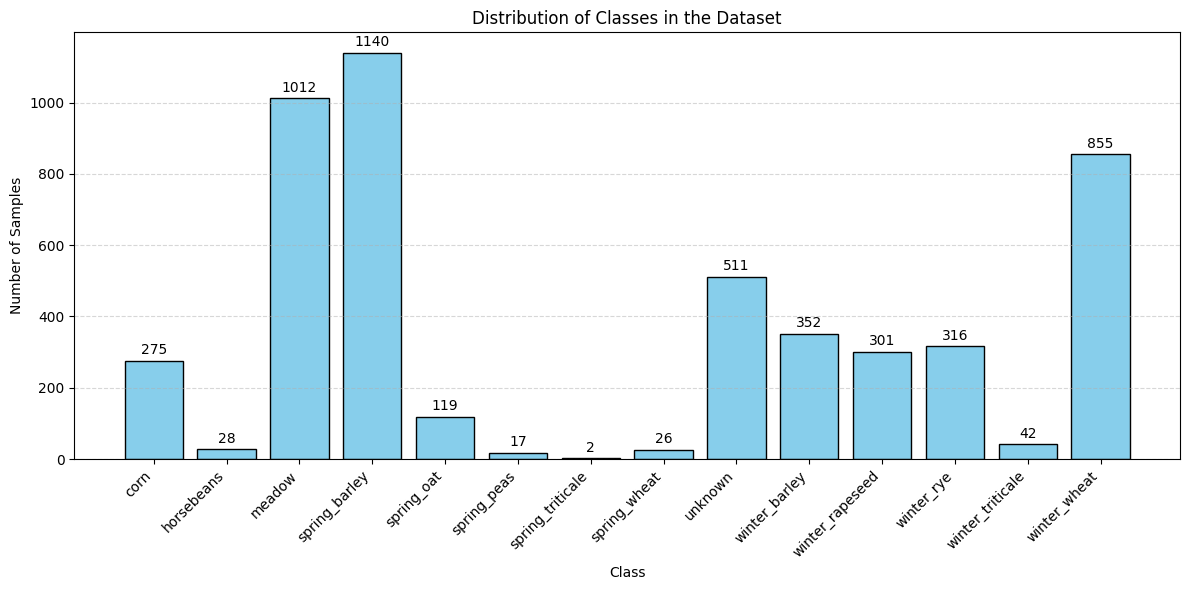

In [4]:
labels, counts = np.unique(dataset.get_labels(), return_counts=True)
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
label_names = [idx_to_class[lbl] for lbl in labels]
plot_distribution(label_names, counts, save_path="figures/init_distr")


Keeping 8 classes out of 14 total.
4762


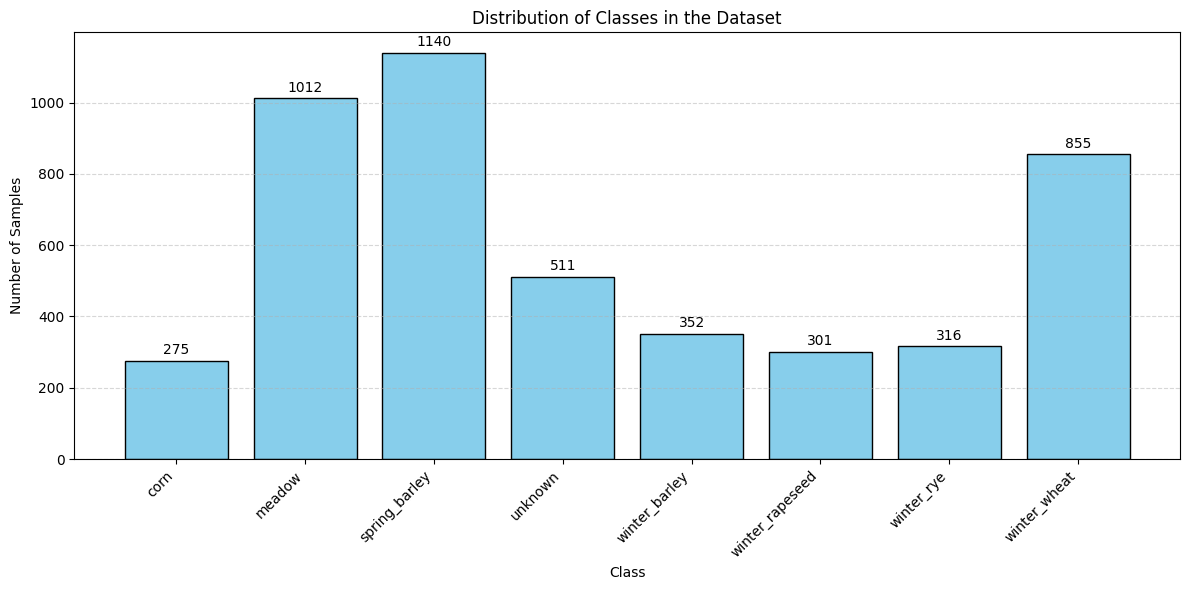

In [5]:
valid_labels = labels[counts >= 200]

print(f"Keeping {len(valid_labels)} classes out of {len(labels)} total.")

label_remap = {old: new for new, old in enumerate(valid_labels)}

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
new_class_names = {label_remap[old]: idx_to_class[old] for old in valid_labels}

# filter and samples
filtered_samples = []
filtered_idxs = []
for sample in dataset.samples:
    path, parcel_idx, y, extra = sample
    if y in valid_labels:
        new_y = label_remap[y]
        filtered_samples.append((path, parcel_idx, new_y, extra))
        filtered_idxs.append(parcel_idx)

dataset.samples = filtered_samples
dataset.class_to_idx = {name: new_idx for new_idx, name in new_class_names.items()}

labels, counts = np.unique([s[2] for s in dataset.samples], return_counts=True)
label_names = [new_class_names[lbl] for lbl in labels]
print(len(dataset))
plot_distribution(label_names, counts, "figures/filtered_distr")

In [6]:
filtered_dataset = PixelSetData(ROOT_DIR, SOURCE_DIR, list(new_class_names.values()), with_extra=True, indices=filtered_idxs)

In [7]:
filtered_dataset[0]

{'index': 0,
 'parcel_index': 0,
 'pixels': array([[[1749, 1726, 1807, ..., 1839, 1856, 1889],
         [1214, 1188, 1201, ..., 1283, 1300, 1318],
         [1185, 1160, 1169, ..., 1333, 1290, 1315],
         ...,
         [2196, 2141, 2056, ..., 1962, 2046, 1954],
         [1396, 1394, 1276, ..., 1022, 1050,  970],
         [ 859,  855,  816, ...,  682,  708,  658]],
 
        [[1193, 1178, 1198, ..., 3014, 3054, 3096],
         [ 812,  810,  803, ..., 2564, 2554, 2646],
         [ 659,  676,  681, ..., 2638, 2714, 2820],
         ...,
         [1013,  994, 1039, ..., 3245, 3232, 3312],
         [ 887,  893,  905, ..., 2628, 2650, 2726],
         [ 528,  534,  550, ..., 2021, 2034, 2096]],
 
        [[   0,    0,    0, ...,    0,    0,    0],
         [   0,    0,    0, ...,    0,    0,    0],
         [   0,    0,    0, ...,    0,    0,    0],
         ...,
         [   0,    0,    0, ...,    0,    0,    0],
         [   0,    0,    0, ...,    0,    0,    0],
         [   0,    0,    

In [8]:
cv_loaders = get_dataloaders_for_cv(filtered_dataset, n_splits=5, sample_pixels=32, batch_size=128)

In [9]:
training_folds_stats = []
for i, (train_dl, _) in enumerate(cv_loaders):
    print(f"Computing per channel mean and std of the training data for fold {i}")
    means, stds = compute_band_stats_from_dl(train_dl)
    training_folds_stats.append((means, stds))

Computing per channel mean and std of the training data for fold 0
Computing per channel mean and std of the training data for fold 1
Computing per channel mean and std of the training data for fold 2
Computing per channel mean and std of the training data for fold 3
Computing per channel mean and std of the training data for fold 4


In [11]:
model = PseTae(num_classes=len(new_class_names.values()))
logits = model.param_ratio()

TOTAL TRAINABLE PARAMETERS : 163400
RATIOS: Spatial  12.1% , Temporal  81.4% , Classifier   6.5%


In [12]:
def normalize_batch(batch, mean, std):
    pixels = batch["pixels"].float()
    # broadcast to (1, C, 1)
    mean = mean[None, :, None]
    std = std[None, :, None]
    batch["pixels"] = (pixels - mean) / (std + 1e-6)
    batch["extra"] = batch["extra"].float()
    return batch


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [14]:
def train_one_epoch(model, optimizer, train_dl, per_channel_means, per_channel_stds, device):
    criterion = CrossEntropyLoss()
    curr_loss = 0.
    model.to(device)
    model.train()
    for i, batch in tqdm(enumerate(train_dl), desc="Training...", total=len(train_dl)):
        batch = normalize_batch(batch, per_channel_means, per_channel_stds)
        batch["pixels"] = batch["pixels"].to(device)
        batch["valid_pixels"] = batch["valid_pixels"].to(device)
        batch["positions"] = batch["positions"].to(device)
        batch["extra"] = batch["extra"].to(device)
        batch["label"] = batch["label"].to(device)
        
        optimizer.zero_grad()
        logits = model(pixels=batch["pixels"], mask=batch["valid_pixels"], positions=batch["positions"], extra=batch["extra"])
        loss = criterion(logits, batch["label"])
        loss.backward()
        optimizer.step()
        curr_loss += loss.item()
    return curr_loss / len(train_dl)


In [15]:
def calculate_val_metrics(all_preds, all_labels, conf_matrix=False):
    accuracy = accuracy_score(all_labels, all_preds)
    macro_pres = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    macro_rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    weighted_pres = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    weighted_rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    if conf_matrix:
        cm = confusion_matrix(all_labels, all_preds)
        return accuracy, macro_pres, macro_rec, macro_f1, weighted_pres, weighted_rec, weighted_f1, cm
    else:
        return accuracy, macro_pres, macro_rec, macro_f1, weighted_pres, weighted_rec, weighted_f1


In [16]:
def validate(model, val_dl, per_channel_means, per_channel_stds, device):
    criterion = CrossEntropyLoss()
    curr_loss, all_preds, all_labels = 0., [], []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for i, batch in tqdm(enumerate(val_dl), desc="Validating...", total=len(val_dl)):
            batch = normalize_batch(batch, per_channel_means, per_channel_stds)
            batch["pixels"] = batch["pixels"].to(device)
            batch["valid_pixels"] = batch["valid_pixels"].to(device)
            batch["positions"] = batch["positions"].to(device)
            batch["extra"] = batch["extra"].to(device)
            batch["label"] = batch["label"].to(device)

            logits = model(pixels=batch["pixels"], mask=batch["valid_pixels"], positions=batch["positions"], extra=batch["extra"])
            loss = criterion(logits, batch["label"])
            curr_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(batch["label"].cpu())
    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    return curr_loss / len(val_dl), all_labels, all_preds

In [17]:
per_phase_accs, per_phase_macro_pres, per_phase_macro_rec, per_phase_macro_f1 = [], [], [], [],
per_phase_weighted_pres, per_phase_weighted_rec, per_phase_weighted_f1 = [], [], []

for phase_idx, (train_dl, val_dl) in enumerate(cv_loaders):
    all_accs, all_macro_pres, all_macro_rec, all_macro_f1, all_weighted_pres, all_weighted_rec, all_weighted_f1 = [], [], [], [], [], [], []
    per_channel_means, per_channel_stds = training_folds_stats[phase_idx]

    print(f"Training for phase {phase_idx}")
    model = PseTae(num_classes=len(new_class_names.values()))
    optimizer = Adam(params=model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.3, patience=5, verbose=True)
    best_val_loss = 1000.
    for epoch in range(EPOCHS):
        avg_train_loss = train_one_epoch(model, optimizer, train_dl, per_channel_means, per_channel_stds, device)
        avg_val_loss, all_val_labels, all_val_preds = validate(model, val_dl, per_channel_means, per_channel_stds, device)
        accuracy, macro_pres, macro_rec, macro_f1, weighted_pres, weighted_rec, weighted_f1 = calculate_val_metrics(all_val_preds, all_val_labels)
        scheduler.step(avg_val_loss)
        all_accs.append(accuracy), all_macro_pres.append(macro_pres), all_macro_rec.append(macro_rec), all_macro_f1.append(macro_f1) 
        all_weighted_pres.append(weighted_pres), all_weighted_rec.append(weighted_rec), all_weighted_f1.append(weighted_f1)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f"best_models/best_model_phase_{phase_idx}.pt")
            print("Saved new best model!")
            
        print(f"Epoch: {epoch + 1}\n\tAvg Training Loss: {avg_train_loss: .2f}\n\tAvg Validation Loss: {avg_val_loss: .2f}")
        print(f"\tAccuracy {accuracy: .2f}:")
        print(f"\tPrecision (macro): {macro_pres: .2f}")
        print(f"\tRecall (macro): {macro_rec: .2f}")
        print(f"\tF1 Score (macro): {macro_f1: .2f}")
        print(f"\tPrecision (weighted): {weighted_pres: .2f}")
        print(f"\tRecall (weighted): {weighted_rec: .2f}")
        print(f"\tF1 Score (weighted): {weighted_f1: .2f}")

    
    per_phase_accs.append(all_accs), per_phase_macro_pres.append(all_macro_pres), per_phase_macro_rec.append(all_macro_rec), per_phase_macro_f1.append(all_macro_f1) 
    per_phase_weighted_pres.append(all_weighted_pres), per_phase_weighted_rec.append(all_weighted_rec), per_phase_weighted_f1.append(all_weighted_f1)
        
    

Training for phase 0


Validating...: 100%|██████████| 953/953 [00:04<00:00, 237.91it/s]


Epoch: 1
	Avg Training Loss:  2.01
	Avg Validation Loss:  1.96
	Accuracy  0.23:
	Precision (macro):  0.08
	Recall (macro):  0.16
	F1 Score (macro):  0.09
	Precision (weighted):  0.13
	Recall (weighted):  0.23
	F1 Score (weighted):  0.13


Validating...: 100%|██████████| 953/953 [00:03<00:00, 257.50it/s]


Epoch: 2
	Avg Training Loss:  1.91
	Avg Validation Loss:  1.98
	Accuracy  0.24:
	Precision (macro):  0.08
	Recall (macro):  0.16
	F1 Score (macro):  0.10
	Precision (weighted):  0.13
	Recall (weighted):  0.24
	F1 Score (weighted):  0.15


Validating...: 100%|██████████| 953/953 [00:03<00:00, 256.47it/s]


Epoch: 3
	Avg Training Loss:  1.89
	Avg Validation Loss:  1.99
	Accuracy  0.24:
	Precision (macro):  0.08
	Recall (macro):  0.16
	F1 Score (macro):  0.10
	Precision (weighted):  0.13
	Recall (weighted):  0.24
	F1 Score (weighted):  0.16


Validating...: 100%|██████████| 953/953 [00:03<00:00, 254.42it/s]


Epoch: 4
	Avg Training Loss:  1.87
	Avg Validation Loss:  2.02
	Accuracy  0.24:
	Precision (macro):  0.10
	Recall (macro):  0.16
	F1 Score (macro):  0.12
	Precision (weighted):  0.16
	Recall (weighted):  0.24
	F1 Score (weighted):  0.19


Validating...: 100%|██████████| 953/953 [00:03<00:00, 257.94it/s]


Epoch: 5
	Avg Training Loss:  1.87
	Avg Validation Loss:  2.04
	Accuracy  0.25:
	Precision (macro):  0.09
	Recall (macro):  0.17
	F1 Score (macro):  0.12
	Precision (weighted):  0.15
	Recall (weighted):  0.25
	F1 Score (weighted):  0.19


Validating...: 100%|██████████| 953/953 [00:03<00:00, 247.30it/s]


Epoch: 6
	Avg Training Loss:  1.86
	Avg Validation Loss:  2.13
	Accuracy  0.23:
	Precision (macro):  0.08
	Recall (macro):  0.15
	F1 Score (macro):  0.09
	Precision (weighted):  0.13
	Recall (weighted):  0.23
	F1 Score (weighted):  0.14


Validating...: 100%|██████████| 953/953 [00:03<00:00, 247.00it/s]


Epoch: 7
	Avg Training Loss:  1.85
	Avg Validation Loss:  2.17
	Accuracy  0.24:
	Precision (macro):  0.09
	Recall (macro):  0.16
	F1 Score (macro):  0.09
	Precision (weighted):  0.15
	Recall (weighted):  0.24
	F1 Score (weighted):  0.13


Validating...: 100%|██████████| 953/953 [00:03<00:00, 256.53it/s]


Epoch: 8
	Avg Training Loss:  1.74
	Avg Validation Loss:  2.91
	Accuracy  0.23:
	Precision (macro):  0.05
	Recall (macro):  0.16
	F1 Score (macro):  0.08
	Precision (weighted):  0.07
	Recall (weighted):  0.23
	F1 Score (weighted):  0.11


Validating...: 100%|██████████| 953/953 [00:03<00:00, 258.27it/s]


Epoch: 9
	Avg Training Loss:  1.64
	Avg Validation Loss:  2.39
	Accuracy  0.14:
	Precision (macro):  0.04
	Recall (macro):  0.13
	F1 Score (macro):  0.05
	Precision (weighted):  0.05
	Recall (weighted):  0.14
	F1 Score (weighted):  0.07


Validating...: 100%|██████████| 953/953 [00:03<00:00, 254.35it/s]


Epoch: 10
	Avg Training Loss:  1.59
	Avg Validation Loss:  2.43
	Accuracy  0.26:
	Precision (macro):  0.12
	Recall (macro):  0.17
	F1 Score (macro):  0.11
	Precision (weighted):  0.21
	Recall (weighted):  0.26
	F1 Score (weighted):  0.17
Training for phase 1


Validating...: 100%|██████████| 953/953 [00:03<00:00, 252.99it/s]


Epoch: 1
	Avg Training Loss:  1.99
	Avg Validation Loss:  1.94
	Accuracy  0.27:
	Precision (macro):  0.06
	Recall (macro):  0.15
	F1 Score (macro):  0.09
	Precision (weighted):  0.11
	Recall (weighted):  0.27
	F1 Score (weighted):  0.16


Validating...: 100%|██████████| 953/953 [00:03<00:00, 249.51it/s]


Epoch: 2
	Avg Training Loss:  1.91
	Avg Validation Loss:  1.91
	Accuracy  0.26:
	Precision (macro):  0.09
	Recall (macro):  0.16
	F1 Score (macro):  0.10
	Precision (weighted):  0.15
	Recall (weighted):  0.26
	F1 Score (weighted):  0.18


Validating...: 100%|██████████| 953/953 [00:03<00:00, 248.64it/s]


Epoch: 3
	Avg Training Loss:  1.91
	Avg Validation Loss:  1.91
	Accuracy  0.24:
	Precision (macro):  0.09
	Recall (macro):  0.14
	F1 Score (macro):  0.10
	Precision (weighted):  0.15
	Recall (weighted):  0.24
	F1 Score (weighted):  0.17


Validating...: 100%|██████████| 953/953 [00:03<00:00, 248.82it/s]


Epoch: 4
	Avg Training Loss:  1.90
	Avg Validation Loss:  1.93
	Accuracy  0.25:
	Precision (macro):  0.09
	Recall (macro):  0.15
	F1 Score (macro):  0.09
	Precision (weighted):  0.15
	Recall (weighted):  0.25
	F1 Score (weighted):  0.16


Validating...: 100%|██████████| 953/953 [00:03<00:00, 257.41it/s]


Epoch: 5
	Avg Training Loss:  1.89
	Avg Validation Loss:  1.92
	Accuracy  0.27:
	Precision (macro):  0.09
	Recall (macro):  0.17
	F1 Score (macro):  0.10
	Precision (weighted):  0.16
	Recall (weighted):  0.27
	F1 Score (weighted):  0.16


Validating...: 100%|██████████| 953/953 [00:03<00:00, 251.19it/s]


Epoch: 6
	Avg Training Loss:  1.88
	Avg Validation Loss:  1.92
	Accuracy  0.24:
	Precision (macro):  0.08
	Recall (macro):  0.14
	F1 Score (macro):  0.09
	Precision (weighted):  0.13
	Recall (weighted):  0.24
	F1 Score (weighted):  0.15


Validating...: 100%|██████████| 953/953 [00:03<00:00, 249.32it/s]


Epoch: 7
	Avg Training Loss:  1.84
	Avg Validation Loss:  1.85
	Accuracy  0.30:
	Precision (macro):  0.09
	Recall (macro):  0.17
	F1 Score (macro):  0.11
	Precision (weighted):  0.15
	Recall (weighted):  0.30
	F1 Score (weighted):  0.19


Validating...: 100%|██████████| 953/953 [00:03<00:00, 252.77it/s]


Epoch: 8
	Avg Training Loss:  1.71
	Avg Validation Loss:  2.33
	Accuracy  0.29:
	Precision (macro):  0.11
	Recall (macro):  0.17
	F1 Score (macro):  0.11
	Precision (weighted):  0.19
	Recall (weighted):  0.29
	F1 Score (weighted):  0.19


Validating...: 100%|██████████| 953/953 [00:03<00:00, 248.70it/s]


Epoch: 9
	Avg Training Loss:  1.64
	Avg Validation Loss:  2.34
	Accuracy  0.25:
	Precision (macro):  0.06
	Recall (macro):  0.14
	F1 Score (macro):  0.09
	Precision (weighted):  0.11
	Recall (weighted):  0.25
	F1 Score (weighted):  0.14


Validating...: 100%|██████████| 953/953 [00:03<00:00, 251.66it/s]


Epoch: 10
	Avg Training Loss:  1.54
	Avg Validation Loss:  1.71
	Accuracy  0.38:
	Precision (macro):  0.16
	Recall (macro):  0.22
	F1 Score (macro):  0.18
	Precision (weighted):  0.25
	Recall (weighted):  0.38
	F1 Score (weighted):  0.30
Training for phase 2


Validating...: 100%|██████████| 952/952 [00:03<00:00, 252.74it/s]


Epoch: 1
	Avg Training Loss:  2.01
	Avg Validation Loss:  1.97
	Accuracy  0.23:
	Precision (macro):  0.10
	Recall (macro):  0.17
	F1 Score (macro):  0.10
	Precision (weighted):  0.17
	Recall (weighted):  0.23
	F1 Score (weighted):  0.15


Validating...: 100%|██████████| 952/952 [00:03<00:00, 252.13it/s]


Epoch: 2
	Avg Training Loss:  1.93
	Avg Validation Loss:  1.92
	Accuracy  0.24:
	Precision (macro):  0.10
	Recall (macro):  0.17
	F1 Score (macro):  0.10
	Precision (weighted):  0.17
	Recall (weighted):  0.24
	F1 Score (weighted):  0.15


Validating...: 100%|██████████| 952/952 [00:03<00:00, 256.74it/s]


Epoch: 3
	Avg Training Loss:  1.90
	Avg Validation Loss:  1.89
	Accuracy  0.25:
	Precision (macro):  0.10
	Recall (macro):  0.17
	F1 Score (macro):  0.11
	Precision (weighted):  0.17
	Recall (weighted):  0.25
	F1 Score (weighted):  0.18


Validating...: 100%|██████████| 952/952 [00:03<00:00, 253.01it/s]


Epoch: 4
	Avg Training Loss:  1.90
	Avg Validation Loss:  1.90
	Accuracy  0.24:
	Precision (macro):  0.10
	Recall (macro):  0.17
	F1 Score (macro):  0.11
	Precision (weighted):  0.17
	Recall (weighted):  0.24
	F1 Score (weighted):  0.17


Validating...: 100%|██████████| 952/952 [00:03<00:00, 256.13it/s]


Epoch: 5
	Avg Training Loss:  1.89
	Avg Validation Loss:  1.99
	Accuracy  0.23:
	Precision (macro):  0.09
	Recall (macro):  0.16
	F1 Score (macro):  0.10
	Precision (weighted):  0.16
	Recall (weighted):  0.23
	F1 Score (weighted):  0.16


Validating...: 100%|██████████| 952/952 [00:03<00:00, 254.29it/s]


Epoch: 6
	Avg Training Loss:  1.86
	Avg Validation Loss:  1.92
	Accuracy  0.28:
	Precision (macro):  0.08
	Recall (macro):  0.14
	F1 Score (macro):  0.09
	Precision (weighted):  0.14
	Recall (weighted):  0.28
	F1 Score (weighted):  0.17


Validating...: 100%|██████████| 952/952 [00:03<00:00, 258.08it/s]


Epoch: 7
	Avg Training Loss:  1.74
	Avg Validation Loss:  1.94
	Accuracy  0.30:
	Precision (macro):  0.12
	Recall (macro):  0.17
	F1 Score (macro):  0.14
	Precision (weighted):  0.19
	Recall (weighted):  0.30
	F1 Score (weighted):  0.23


Validating...: 100%|██████████| 952/952 [00:03<00:00, 256.48it/s]


Epoch: 8
	Avg Training Loss:  1.63
	Avg Validation Loss:  1.82
	Accuracy  0.32:
	Precision (macro):  0.18
	Recall (macro):  0.20
	F1 Score (macro):  0.16
	Precision (weighted):  0.26
	Recall (weighted):  0.32
	F1 Score (weighted):  0.25


Validating...: 100%|██████████| 952/952 [00:03<00:00, 255.08it/s]


Epoch: 9
	Avg Training Loss:  1.55
	Avg Validation Loss:  2.96
	Accuracy  0.21:
	Precision (macro):  0.11
	Recall (macro):  0.15
	F1 Score (macro):  0.08
	Precision (weighted):  0.19
	Recall (weighted):  0.21
	F1 Score (weighted):  0.13


Validating...: 100%|██████████| 952/952 [00:03<00:00, 254.68it/s]


Epoch: 10
	Avg Training Loss:  1.42
	Avg Validation Loss:  1.71
	Accuracy  0.38:
	Precision (macro):  0.17
	Recall (macro):  0.22
	F1 Score (macro):  0.19
	Precision (weighted):  0.28
	Recall (weighted):  0.38
	F1 Score (weighted):  0.31
Training for phase 3


Validating...: 100%|██████████| 952/952 [00:03<00:00, 254.68it/s]


Epoch: 1
	Avg Training Loss:  2.04
	Avg Validation Loss:  1.93
	Accuracy  0.26:
	Precision (macro):  0.09
	Recall (macro):  0.15
	F1 Score (macro):  0.09
	Precision (weighted):  0.16
	Recall (weighted):  0.26
	F1 Score (weighted):  0.17


Validating...: 100%|██████████| 952/952 [00:03<00:00, 254.62it/s]


Epoch: 2
	Avg Training Loss:  1.93
	Avg Validation Loss:  1.91
	Accuracy  0.26:
	Precision (macro):  0.07
	Recall (macro):  0.15
	F1 Score (macro):  0.09
	Precision (weighted):  0.13
	Recall (weighted):  0.26
	F1 Score (weighted):  0.16


Validating...: 100%|██████████| 952/952 [00:03<00:00, 254.94it/s]


Epoch: 3
	Avg Training Loss:  1.91
	Avg Validation Loss:  1.88
	Accuracy  0.29:
	Precision (macro):  0.11
	Recall (macro):  0.17
	F1 Score (macro):  0.13
	Precision (weighted):  0.19
	Recall (weighted):  0.29
	F1 Score (weighted):  0.22


Validating...: 100%|██████████| 952/952 [00:03<00:00, 255.42it/s]


Epoch: 4
	Avg Training Loss:  1.90
	Avg Validation Loss:  1.89
	Accuracy  0.27:
	Precision (macro):  0.11
	Recall (macro):  0.17
	F1 Score (macro):  0.11
	Precision (weighted):  0.19
	Recall (weighted):  0.27
	F1 Score (weighted):  0.18


Validating...: 100%|██████████| 952/952 [00:03<00:00, 255.95it/s]


Epoch: 5
	Avg Training Loss:  1.89
	Avg Validation Loss:  1.88
	Accuracy  0.27:
	Precision (macro):  0.11
	Recall (macro):  0.15
	F1 Score (macro):  0.10
	Precision (weighted):  0.20
	Recall (weighted):  0.27
	F1 Score (weighted):  0.19


Validating...: 100%|██████████| 952/952 [00:03<00:00, 262.43it/s]


Epoch: 6
	Avg Training Loss:  1.89
	Avg Validation Loss:  1.93
	Accuracy  0.27:
	Precision (macro):  0.10
	Recall (macro):  0.16
	F1 Score (macro):  0.11
	Precision (weighted):  0.17
	Recall (weighted):  0.27
	F1 Score (weighted):  0.18


Validating...: 100%|██████████| 952/952 [00:03<00:00, 255.32it/s]


Epoch: 7
	Avg Training Loss:  1.88
	Avg Validation Loss:  2.00
	Accuracy  0.24:
	Precision (macro):  0.12
	Recall (macro):  0.14
	F1 Score (macro):  0.08
	Precision (weighted):  0.21
	Recall (weighted):  0.24
	F1 Score (weighted):  0.14


Validating...: 100%|██████████| 952/952 [00:03<00:00, 252.93it/s]


Epoch: 8
	Avg Training Loss:  1.78
	Avg Validation Loss:  2.13
	Accuracy  0.28:
	Precision (macro):  0.10
	Recall (macro):  0.16
	F1 Score (macro):  0.10
	Precision (weighted):  0.17
	Recall (weighted):  0.28
	F1 Score (weighted):  0.19


Validating...: 100%|██████████| 952/952 [00:03<00:00, 255.06it/s]


Epoch: 9
	Avg Training Loss:  1.68
	Avg Validation Loss:  2.04
	Accuracy  0.24:
	Precision (macro):  0.06
	Recall (macro):  0.13
	F1 Score (macro):  0.08
	Precision (weighted):  0.11
	Recall (weighted):  0.24
	F1 Score (weighted):  0.15


Validating...: 100%|██████████| 952/952 [00:03<00:00, 254.62it/s]


Epoch: 10
	Avg Training Loss:  1.58
	Avg Validation Loss:  1.58
	Accuracy  0.43:
	Precision (macro):  0.25
	Recall (macro):  0.24
	F1 Score (macro):  0.19
	Precision (weighted):  0.35
	Recall (weighted):  0.43
	F1 Score (weighted):  0.33
Training for phase 4


Validating...: 100%|██████████| 952/952 [00:03<00:00, 258.73it/s]


Epoch: 1
	Avg Training Loss:  2.07
	Avg Validation Loss:  1.88
	Accuracy  0.33:
	Precision (macro):  0.14
	Recall (macro):  0.17
	F1 Score (macro):  0.13
	Precision (weighted):  0.23
	Recall (weighted):  0.33
	F1 Score (weighted):  0.23


Validating...: 100%|██████████| 952/952 [00:03<00:00, 256.36it/s]


Epoch: 2
	Avg Training Loss:  1.97
	Avg Validation Loss:  1.85
	Accuracy  0.33:
	Precision (macro):  0.14
	Recall (macro):  0.17
	F1 Score (macro):  0.12
	Precision (weighted):  0.23
	Recall (weighted):  0.33
	F1 Score (weighted):  0.22


Validating...: 100%|██████████| 952/952 [00:03<00:00, 252.15it/s]


Epoch: 3
	Avg Training Loss:  1.92
	Avg Validation Loss:  1.85
	Accuracy  0.31:
	Precision (macro):  0.07
	Recall (macro):  0.16
	F1 Score (macro):  0.10
	Precision (weighted):  0.14
	Recall (weighted):  0.31
	F1 Score (weighted):  0.19


Validating...: 100%|██████████| 952/952 [00:03<00:00, 249.98it/s]


Epoch: 4
	Avg Training Loss:  1.92
	Avg Validation Loss:  1.85
	Accuracy  0.31:
	Precision (macro):  0.12
	Recall (macro):  0.16
	F1 Score (macro):  0.10
	Precision (weighted):  0.21
	Recall (weighted):  0.31
	F1 Score (weighted):  0.20


Validating...: 100%|██████████| 952/952 [00:03<00:00, 252.55it/s]


Epoch: 5
	Avg Training Loss:  1.90
	Avg Validation Loss:  1.85
	Accuracy  0.30:
	Precision (macro):  0.11
	Recall (macro):  0.16
	F1 Score (macro):  0.11
	Precision (weighted):  0.20
	Recall (weighted):  0.30
	F1 Score (weighted):  0.21


Validating...: 100%|██████████| 952/952 [00:03<00:00, 256.46it/s]


Epoch: 6
	Avg Training Loss:  1.90
	Avg Validation Loss:  1.84
	Accuracy  0.33:
	Precision (macro):  0.11
	Recall (macro):  0.17
	F1 Score (macro):  0.13
	Precision (weighted):  0.20
	Recall (weighted):  0.33
	F1 Score (weighted):  0.24


Validating...: 100%|██████████| 952/952 [00:03<00:00, 252.68it/s]


Epoch: 7
	Avg Training Loss:  1.89
	Avg Validation Loss:  1.89
	Accuracy  0.33:
	Precision (macro):  0.13
	Recall (macro):  0.17
	F1 Score (macro):  0.12
	Precision (weighted):  0.23
	Recall (weighted):  0.33
	F1 Score (weighted):  0.23


Validating...: 100%|██████████| 952/952 [00:03<00:00, 254.50it/s]


Epoch: 8
	Avg Training Loss:  1.87
	Avg Validation Loss:  2.01
	Accuracy  0.22:
	Precision (macro):  0.06
	Recall (macro):  0.14
	F1 Score (macro):  0.08
	Precision (weighted):  0.10
	Recall (weighted):  0.22
	F1 Score (weighted):  0.13


Validating...: 100%|██████████| 952/952 [00:03<00:00, 257.07it/s]


Epoch: 9
	Avg Training Loss:  1.73
	Avg Validation Loss:  2.11
	Accuracy  0.19:
	Precision (macro):  0.02
	Recall (macro):  0.12
	F1 Score (macro):  0.04
	Precision (weighted):  0.04
	Recall (weighted):  0.19
	F1 Score (weighted):  0.06


Validating...: 100%|██████████| 952/952 [00:03<00:00, 256.74it/s]

Epoch: 10
	Avg Training Loss:  1.66
	Avg Validation Loss:  2.00
	Accuracy  0.26:
	Precision (macro):  0.17
	Recall (macro):  0.16
	F1 Score (macro):  0.10
	Precision (weighted):  0.32
	Recall (weighted):  0.26
	F1 Score (weighted):  0.16


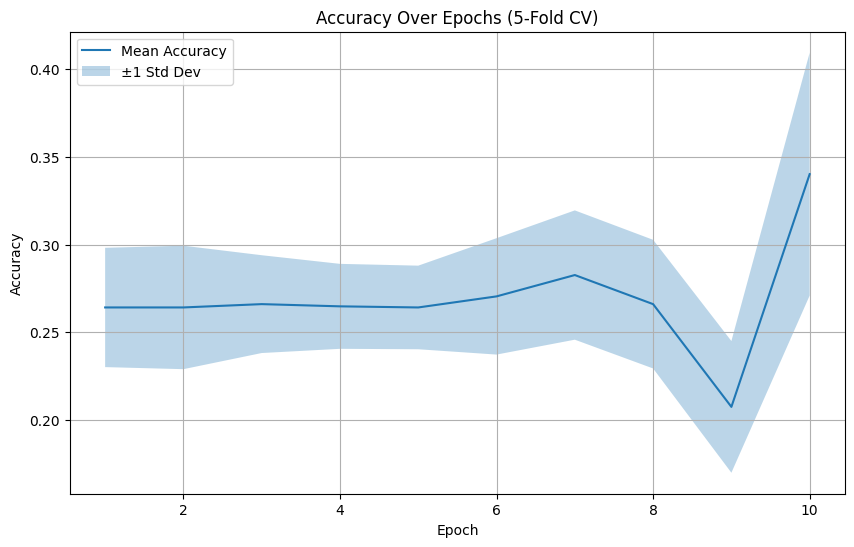

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to numpy array for easier manipulation
accs_array = np.array(per_phase_accs)  # shape: (num_folds, num_epochs)
mean_accs = np.mean(accs_array, axis=0)
std_accs = np.std(accs_array, axis=0)

epochs = np.arange(1, len(mean_accs) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, mean_accs, label='Mean Accuracy')
plt.fill_between(epochs, mean_accs - std_accs, mean_accs + std_accs, alpha=0.3, label='±1 Std Dev')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs (5-Fold CV)')
plt.legend()
plt.grid(True)
plt.show()


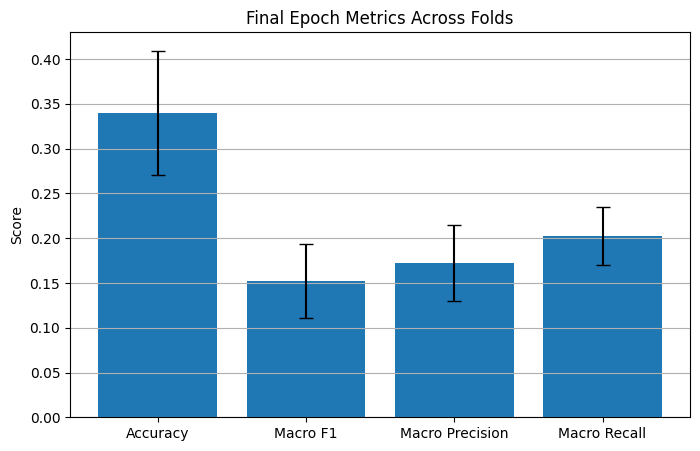

In [19]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Accuracy', 'Macro F1', 'Macro Precision', 'Macro Recall']
means = [
    np.mean([fold[-1] for fold in per_phase_accs]),  # use last epoch values
    np.mean([fold[-1] for fold in per_phase_macro_f1]),
    np.mean([fold[-1] for fold in per_phase_macro_pres]),
    np.mean([fold[-1] for fold in per_phase_macro_rec])
]
stds = [
    np.std([fold[-1] for fold in per_phase_accs]),
    np.std([fold[-1] for fold in per_phase_macro_f1]),
    np.std([fold[-1] for fold in per_phase_macro_pres]),
    np.std([fold[-1] for fold in per_phase_macro_rec])
]

x = np.arange(len(labels))
plt.figure(figsize=(8, 5))
plt.bar(x, means, yerr=stds, capsize=5)
plt.xticks(x, labels)
plt.ylabel('Score')
plt.title('Final Epoch Metrics Across Folds')
plt.grid(True, axis='y')
plt.show()


In [ ]:
### TODO
"""
Plot metrics with mean and std stuff
put all funcs in utils.py
add comments
save best model weight + confusion matrix for it
add scheduler
"""